## Iceberg/ship detection
dataset https://www.kaggle.com/c/statoil-iceberg-classifier-challenge

In [1]:
import json, sys, random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_file = open('datasets/icebergs/train.json')
dataset = json.load(train_file)
train_file.close()
print(dataset[0].keys())

dict_keys(['is_iceberg', 'band_2', 'id', 'inc_angle', 'band_1'])


In [3]:
# no idea is inc_angle useful. Seems like it is distribution is narrow. Leave it out
inc = np.array([float(x['inc_angle']) for x in dataset if x['inc_angle'] != 'na'])
inc.mean(), inc.std()

(39.26870747790618, 3.8384390421193935)

In [4]:
# using minmax scaling for 'images'. Standard scaling yields strange green-red-whatever spots
x1 = []
x2 = []
labels = []
for item in dataset:
    b1 = np.array(item["band_1"]).astype(np.float32).reshape(75, 75, 1)
    b1_mx = b1.max()
    b1_mn = b1.min()
    b1 = (b1 - b1_mn)/(b1_mx - b1_mn)
    # b1 -= b1.mean()
    # b1 /= b1.std()
    x1.append(b1)
    
    b2 = np.array(item["band_2"]).astype(np.float32).reshape(75, 75, 1)
    b2_mx = b2.max()
    b2_mn = b2.min()
    b2 = (b2 - b2_mn)/(b2_mx - b2_mn)
    x2.append(b2)
    
    labels.append(item['is_iceberg'])
    
X_band1 = np.array(x1)
X_band2 = np.array(x2)
labels = np.array(labels)

In [5]:
# approx equal count of ships and icebergs
np.bincount(labels)

array([851, 753])

In [6]:
X_band1.shape

(1604, 75, 75, 1)

1


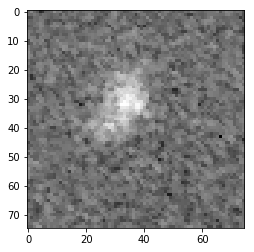

In [7]:
num = 201
# plt.imshow(X_band1[num, :, :, 0], cmap='gray')
plt.imshow(X_band2[num, :, :, 0], cmap='gray')
print(labels[num])

In [8]:
# make it 3-dimensional for convenience
images = np.concatenate([X_band1, X_band2, (X_band1+X_band2)/2], axis = 3)
images.shape

(1604, 75, 75, 3)

0


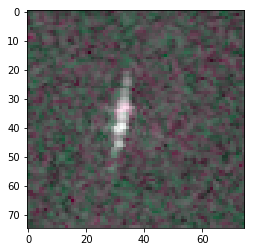

In [9]:
num = 105
plt.imshow(images[num, :, :])
print(labels[num])

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# test will be used in the very end - to make sure val_loss won't differ significantly
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels, test_size=0.3)

In [12]:
X_train.shape, X_test.shape

((1122, 75, 75, 3), (482, 75, 75, 3))

In [13]:
# enlarge training dataset - horisontal/vertical flip for all images and 90deg rotation. x6 images in total
X_train_v = X_train[:, ::-1, :, :]
X_train_h = X_train[:, :, ::-1, :]
X_train = np.vstack((X_train, X_train_v, X_train_h))


X_train_t = np.transpose(X_train, (0, 2, 1, 3))
X_train = np.vstack((X_train, X_train_t))

In [14]:
X_train.shape

(6732, 75, 75, 3)

In [15]:
y_train = np.concatenate([y_train] * 6)
y_train.shape

(6732,)

In [16]:
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import log_loss

In [21]:
model = models.Sequential()

model.add(layers.Conv2D(32, input_shape=(75, 75, 3), activation='relu', kernel_size=(3, 3), padding='same'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.BatchNormalization(axis = -1))
model.add(layers.Dropout(0.2))

for flt in [32, 64, 64, 64]:
    model.add(layers.Conv2D(flt, activation='relu', kernel_size=(3, 3), padding='same'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.BatchNormalization(axis = -1))
    model.add(layers.Dropout(0.2))
    
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 75, 75, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
batch_normalization_v2_7 (Ba (None, 37, 37, 32)        128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
batch_normalization_v2_8 (Ba (None, 18, 18, 32)       

In [23]:
# stop if val_loss won't become better in 20 epochs, save the best model in terms of val_loss
es = callbacks.EarlyStopping('val_loss', patience=20, mode="min")
best_model = callbacks.ModelCheckpoint('saved_models/icebergs.hdf5', save_best_only=True, monitor='val_loss')

cb = [es, best_model]

In [26]:
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=128, callbacks=cb) # validation_data=(X_test, y_test)

Train on 5385 samples, validate on 1347 samples
Epoch 1/200
5385/5385 [==============================] - 3s 554us/sample - loss: 0.6823 - acc: 0.6611 - val_loss: 0.6930 - val_acc: 0.5308
Epoch 2/200
5385/5385 [==============================] - 2s 348us/sample - loss: 0.5290 - acc: 0.7385 - val_loss: 0.7434 - val_acc: 0.5308
Epoch 3/200
5385/5385 [==============================] - 2s 349us/sample - loss: 0.4547 - acc: 0.7690 - val_loss: 0.8058 - val_acc: 0.5308
Epoch 4/200
5385/5385 [==============================] - 2s 350us/sample - loss: 0.4125 - acc: 0.7929 - val_loss: 0.8585 - val_acc: 0.5308
Epoch 5/200
5385/5385 [==============================] - 2s 351us/sample - loss: 0.3860 - acc: 0.8150 - val_loss: 0.7704 - val_acc: 0.5308
Epoch 6/200
5385/5385 [==============================] - 2s 350us/sample - loss: 0.3710 - acc: 0.8193 - val_loss: 0.9041 - val_acc: 0.5308
Epoch 7/200
5385/5385 [==============================] - 2s 350us/sample - loss: 0.3453 - acc: 0.8282 - val_loss: 0.81

In [24]:
# well, test loss is similar to the best val loss. Not great, not terrible.
model.load_weights('saved_models/icebergs.hdf5')
model.evaluate(X_test, y_test)

482/482 [==============================] - 1s 2ms/sample - loss: 0.1636 - acc: 0.9357


[0.16358055845212144, 0.9356846]

In [25]:
print(y_test[50])
model.predict(X_test[50:51])

1


array([[0.9176329]], dtype=float32)

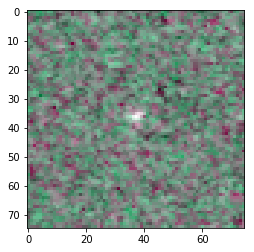

In [26]:
plt.imshow(X_test[50, :, :])

In [27]:
print(y_test[50])

1
